In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym as gym
from gym import spaces

OSError: [WinError 126] The specified module could not be found. Error loading "d:\Python\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [ ]:
# Load dataset
df = pd.read_csv("metrics-with-output.csv")
df

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0
...,...,...,...,...,...,...,...,...,...,...
7184,2023-09-08 11:14:40,1694146480000,22.2%,53.5%,6.52 GB/s,5.67 GB/s,2.40 req/s,0 req/s,1.51 s,0
7185,2023-09-08 11:14:45,1694146485000,27.2%,56.0%,7.37 GB/s,6.49 GB/s,2.60 req/s,0 req/s,1.21 s,0
7186,2023-09-08 11:14:50,1694146490000,7.20%,54.1%,4.76 GB/s,4.02 GB/s,1.40 req/s,0 req/s,285 ms,0
7187,2023-09-08 11:14:55,1694146495000,23.4%,54.6%,6.75 GB/s,5.90 GB/s,2.40 req/s,0 req/s,804 ms,0


In [ ]:
# Menampilkan baris pertama dari data set
df.head()

,Time,Timestamp,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
0,2023-09-08 01:16:00,1694110560000,9.00%,53.5%,7.46 GB/s,6.45 GB/s,2 req/s,0 req/s,607 ms,0
1,2023-09-08 01:16:05,1694110565000,16.6%,53.3%,5.85 GB/s,5.27 GB/s,2.20 req/s,0 req/s,2.09 s,0
2,2023-09-08 01:16:10,1694110570000,20.2%,55.3%,9.06 GB/s,7.96 GB/s,3.20 req/s,0 req/s,3.45 s,0
3,2023-09-08 01:16:15,1694110575000,14.6%,58.0%,8.41 GB/s,7.21 GB/s,3.20 req/s,0 req/s,2.58 s,0
4,2023-09-08 01:16:20,1694110580000,10.2%,53.5%,4.88 GB/s,4.30 GB/s,2.60 req/s,0 req/s,862 ms,0


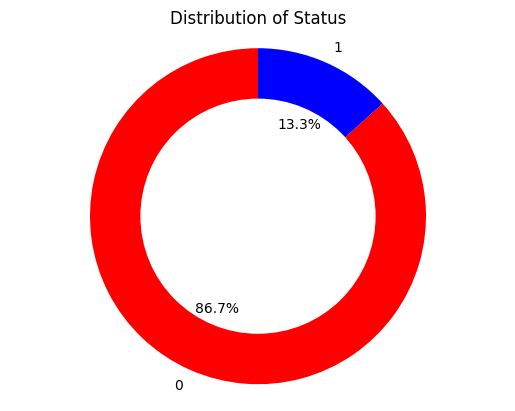

In [ ]:
import matplotlib.pyplot as plt

# Membandingkan jumlah status healthy dan unhealthy dengan donut chart
status_counts = df['Status'].value_counts()

colors = ['red', 'blue']
plt.pie(status_counts, labels=status_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
# menambahkan lingkaran tengah untuk membuat donut chart
plt.gca().add_artist(plt.Circle((0,0), 0.70, fc='white'))
# memastikan lingkaran berukuran sama sehingga terlihat seperti donus
plt.axis('equal')

plt.title('Distribution of Status')
plt.show()

In [ ]:
print(df.dtypes)

Time                  object
Timestamp              int64
cpu_usage             object
memory_usage          object
bandwidth_inbound     object
bandwidth_outbound    object
tps                   object
tps_error             object
response_time         object
Status                 int64
dtype: object


In [ ]:
# Preprocessing data
# Konversi dataset
df['cpu_usage'] = df['cpu_usage'].str.rstrip('%').astype(float) / 100.0
df['memory_usage'] = df['memory_usage'].str.rstrip('%').astype('float') / 100.0
def clean_bandwidth(value):
    if 'GB/s' in value:
        return float(value.replace('GB/s', ''))
    elif 'MB/s' in value:
        return float(value.replace('MB/s', '')) / 1024  # Mengubah MB/s menjadi GB/s
    else:
        return float(value)

df['bandwidth_inbound'] = df['bandwidth_inbound'].apply(clean_bandwidth)
df['bandwidth_outbound'] = df['bandwidth_outbound'].apply(clean_bandwidth)
df['tps'] = df['tps'].str.rstrip(' req/s').astype('float')
df['tps_error'] = df['tps_error'].str.rstrip(' req/s').astype('float')
df['response_time'] = df['response_time'].replace({' ms': '*1e-3', ' s': '*1'}, regex=True).map(pd.eval).astype('float')

In [ ]:
# Info dataset mengenai tipe, jumlah kolom, dll
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7189 entries, 0 to 7188
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time                7189 non-null   object 
 1   Timestamp           7189 non-null   int64  
 2   cpu_usage           7189 non-null   float64
 3   memory_usage        7189 non-null   float64
 4   bandwidth_inbound   7189 non-null   float64
 5   bandwidth_outbound  7189 non-null   float64
 6   tps                 7189 non-null   float64
 7   tps_error           7189 non-null   float64
 8   response_time       7189 non-null   float64
 9   Status              7189 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 561.8+ KB


In [ ]:
# Menampilkan dataset setelah konversi
print(df)

                     Time      Timestamp  cpu_usage  memory_usage  \
0     2023-09-08 01:16:00  1694110560000      0.090         0.535   
1     2023-09-08 01:16:05  1694110565000      0.166         0.533   
2     2023-09-08 01:16:10  1694110570000      0.202         0.553   
3     2023-09-08 01:16:15  1694110575000      0.146         0.580   
4     2023-09-08 01:16:20  1694110580000      0.102         0.535   
...                   ...            ...        ...           ...   
7184  2023-09-08 11:14:40  1694146480000      0.222         0.535   
7185  2023-09-08 11:14:45  1694146485000      0.272         0.560   
7186  2023-09-08 11:14:50  1694146490000      0.072         0.541   
7187  2023-09-08 11:14:55  1694146495000      0.234         0.546   
7188  2023-09-08 11:15:00  1694146500000      0.310         0.538   

      bandwidth_inbound  bandwidth_outbound  tps  tps_error  response_time  \
0                  7.46                6.45  2.0        0.0          0.607   
1              

In [ ]:
# Pembersihan dan penghapusan data yang tidak dipakai
dataset = df.drop(df.columns[[0, 1]], axis=1)
dataset.describe()

,cpu_usage,memory_usage,bandwidth_inbound,bandwidth_outbound,tps,tps_error,response_time,Status
count,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000,7189.000000
mean,0.163090,0.542723,6.318377,5.573617,2.490218,0.170817,1.770724,0.132981
std,0.069272,0.019356,3.193037,2.728239,0.784028,0.548970,1.024615,0.339578
min,0.010000,0.497000,0.056055,0.060645,0.600000,0.000000,0.118000,0.000000
25%,0.118000,0.533000,3.940000,3.540000,2.000000,0.000000,0.952000,0.000000
50%,0.156000,0.539000,5.910000,5.230000,2.400000,0.000000,1.520000,0.000000
75%,0.198000,0.549000,8.310000,7.260000,3.000000,0.000000,2.450000,0.000000
max,1.000000,0.700000,20.400000,17.600000,5.800000,4.600000,7.100000,1.000000


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode Status ke numerik
label_encoder = LabelEncoder()
dataset['Status'] = label_encoder.fit_transform(dataset['Status'])

In [ ]:
dataset['Status']

0       0
1       0
2       0
3       0
4       0
       ..
7184    0
7185    0
7186    0
7187    0
7188    0
Name: Status, Length: 7189, dtype: int64

In [ ]:
# Periksa apakah ada data yang hilang
missing_data = dataset.isnull().sum()
if missing_data.any():
    print("Terdapat missing values yang perlu diimputasi")
    print(missing_data)
else:
    print("Tidak ada missing values dalam dataset")

Tidak ada missing values dalam dataset


In [ ]:
# Split data menjadi feature (X) dan target (y)
X = dataset.drop('Status', axis=1)
y = dataset['Status']

In [ ]:
# Normalisasi data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Mendefinisikan model ppo
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(p=0.3)  # Menambahkan dropout

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PPO:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.95, k_epochs=5, eps_clip=0.1):
        self.policy = PolicyNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.policy_old = PolicyNetwork(state_dim, action_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.k_epochs = k_epochs
    
    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs = torch.softmax(self.policy_old(state), dim=-1)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)
    
    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        old_states = torch.squeeze(torch.stack(memory.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(memory.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs, dim=0)).detach().to(device)
        
        for _ in range(self.k_epochs):
            action_probs = torch.softmax(self.policy(old_states), dim=-1)
            dist = Categorical(action_probs)
            logprobs = dist.log_prob(old_actions)
            entropy = dist.entropy()
            
            ratios = torch.exp(logprobs - old_logprobs)
            
            advantages = rewards - rewards.mean()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            
            state_values = self.policy(old_states).max(dim=1).values
            
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*entropy.mean()
            
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        self.policy_old.load_state_dict(self.policy.state_dict())



class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

    def add_action(self, action):
        self.actions.append(action)

    def add_state(self, state):
        self.states.append(state)

    def add_logprob(self, logprob):
        self.logprobs.append(logprob)

    def add_reward(self, reward):
        self.rewards.append(reward)

    def add_is_terminal(self, is_terminal):
        self.is_terminals.append(is_terminal)


In [ ]:
# Mendefinisikan Environment
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()

        # Load data dari data set
        self.df = dataset

        # Mendefinisikan action dan observation space
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float64)

        self.curent_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_observation()
    
    def step(self):
        self.curent_step += 1
        done = self.curent_step >= len(self.df) - 1

        reward = self._get_reward()
        next_state = self._get_observation()
        
        return next_state, reward, done, {}
    
    def _get_observation(self):
        return self.df.iloc[self.current_step][['cpu_usage', 'memory_usage', 'bandwidth_inbound', 'bandwidth_outbound', 'tps', 'tps_error', 'response_time']].values
    
    def _get_reward(self):
        if self.df.iloc[self.current_step]['Status'] == 0:
            return 1.0
        else:
            return -1.0


In [ ]:
len(dataset)

7189

In [ ]:
# Training Model PPO

env = CustomEnv()

# Use the custom environment with the PPO algorithm
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
ppo = PPO(state_dim, action_dim)
memory = Memory()

max_episodes = 1800
max_timesteps = 2000
update_timestep = 2000
print_freq = 1

time_step = 0
episode_rewards = []

for episode in range(1, max_episodes + 1):
    state = env.reset()
    episode_reward = 0
    for t in range(max_timesteps):
        time_step += 1
        action, logprob = ppo.select_action(state)
        next_state, reward, done, _ = env.step()


        # memory.add_state(torch.FloatTensor(state))
        memory.add_state(torch.FloatTensor(state))
        memory.add_action(torch.tensor(action))
        memory.add_logprob(torch.tensor(logprob))
        memory.add_reward(reward)
        memory.add_is_terminal(done)
        
        state = next_state
        episode_reward += reward


        if time_step % update_timestep == 0:
            ppo.update(memory)
            memory.clear_memory()
            time_step = 0
        
        if done:
            break
    episode_rewards.append(episode_reward)
    if episode % print_freq == 0:
        print("Episode {} \t Total reward: {}".format(episode, episode_reward))

    
        

C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 1 	 Total reward: 2000.0


C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 2 	 Total reward: 2000.0


C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 3 	 Total reward: 2000.0


C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 4 	 Total reward: 1188.0
Episode 5 	 Total reward: 1.0
Episode 6 	 Total reward: 1.0
Episode 7 	 Total reward: 1.0
Episode 8 	 Total reward: 1.0
Episode 9 	 Total reward: 1.0
Episode 10 	 Total reward: 1.0
Episode 11 	 Total reward: 1.0
Episode 12 	 Total reward: 1.0
Episode 13 	 Total reward: 1.0
Episode 14 	 Total reward: 1.0
Episode 15 	 Total reward: 1.0
Episode 16 	 Total reward: 1.0
Episode 17 	 Total reward: 1.0
Episode 18 	 Total reward: 1.0
Episode 19 	 Total reward: 1.0
Episode 20 	 Total reward: 1.0
Episode 21 	 Total reward: 1.0
Episode 22 	 Total reward: 1.0
Episode 23 	 Total reward: 1.0
Episode 24 	 Total reward: 1.0
Episode 25 	 Total reward: 1.0
Episode 26 	 Total reward: 1.0
Episode 27 	 Total reward: 1.0
Episode 28 	 Total reward: 1.0
Episode 29 	 Total reward: 1.0
Episode 30 	 Total reward: 1.0
Episode 31 	 Total reward: 1.0
Episode 32 	 Total reward: 1.0
Episode 33 	 Total reward: 1.0
Episode 34 	 Total reward: 1.0
Episode 35 	 Total reward: 1.0
Episode 36 

C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 293 	 Total reward: 1.0
Episode 294 	 Total reward: 1.0
Episode 295 	 Total reward: 1.0
Episode 296 	 Total reward: 1.0
Episode 297 	 Total reward: 1.0
Episode 298 	 Total reward: 1.0
Episode 299 	 Total reward: 1.0
Episode 300 	 Total reward: 1.0
Episode 301 	 Total reward: 1.0
Episode 302 	 Total reward: 1.0
Episode 303 	 Total reward: 1.0
Episode 304 	 Total reward: 1.0
Episode 305 	 Total reward: 1.0
Episode 306 	 Total reward: 1.0
Episode 307 	 Total reward: 1.0
Episode 308 	 Total reward: 1.0
Episode 309 	 Total reward: 1.0
Episode 310 	 Total reward: 1.0
Episode 311 	 Total reward: 1.0
Episode 312 	 Total reward: 1.0
Episode 313 	 Total reward: 1.0
Episode 314 	 Total reward: 1.0
Episode 315 	 Total reward: 1.0
Episode 316 	 Total reward: 1.0
Episode 317 	 Total reward: 1.0
Episode 318 	 Total reward: 1.0
Episode 319 	 Total reward: 1.0
Episode 320 	 Total reward: 1.0
Episode 321 	 Total reward: 1.0
Episode 322 	 Total reward: 1.0
Episode 323 	 Total reward: 1.0
Episode 

C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 575 	 Total reward: 1.0
Episode 576 	 Total reward: 1.0
Episode 577 	 Total reward: 1.0
Episode 578 	 Total reward: 1.0
Episode 579 	 Total reward: 1.0
Episode 580 	 Total reward: 1.0
Episode 581 	 Total reward: 1.0
Episode 582 	 Total reward: 1.0
Episode 583 	 Total reward: 1.0
Episode 584 	 Total reward: 1.0
Episode 585 	 Total reward: 1.0
Episode 586 	 Total reward: 1.0
Episode 587 	 Total reward: 1.0
Episode 588 	 Total reward: 1.0
Episode 589 	 Total reward: 1.0
Episode 590 	 Total reward: 1.0
Episode 591 	 Total reward: 1.0
Episode 592 	 Total reward: 1.0
Episode 593 	 Total reward: 1.0
Episode 594 	 Total reward: 1.0
Episode 595 	 Total reward: 1.0
Episode 596 	 Total reward: 1.0
Episode 597 	 Total reward: 1.0
Episode 598 	 Total reward: 1.0
Episode 599 	 Total reward: 1.0
Episode 600 	 Total reward: 1.0
Episode 601 	 Total reward: 1.0
Episode 602 	 Total reward: 1.0
Episode 603 	 Total reward: 1.0
Episode 604 	 Total reward: 1.0
Episode 605 	 Total reward: 1.0
Episode 

C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 816 	 Total reward: 1.0
Episode 817 	 Total reward: 1.0
Episode 818 	 Total reward: 1.0
Episode 819 	 Total reward: 1.0
Episode 820 	 Total reward: 1.0
Episode 821 	 Total reward: 1.0
Episode 822 	 Total reward: 1.0
Episode 823 	 Total reward: 1.0
Episode 824 	 Total reward: 1.0
Episode 825 	 Total reward: 1.0
Episode 826 	 Total reward: 1.0
Episode 827 	 Total reward: 1.0
Episode 828 	 Total reward: 1.0
Episode 829 	 Total reward: 1.0
Episode 830 	 Total reward: 1.0
Episode 831 	 Total reward: 1.0
Episode 832 	 Total reward: 1.0
Episode 833 	 Total reward: 1.0
Episode 834 	 Total reward: 1.0
Episode 835 	 Total reward: 1.0
Episode 836 	 Total reward: 1.0
Episode 837 	 Total reward: 1.0
Episode 838 	 Total reward: 1.0
Episode 839 	 Total reward: 1.0
Episode 840 	 Total reward: 1.0
Episode 841 	 Total reward: 1.0
Episode 842 	 Total reward: 1.0
Episode 843 	 Total reward: 1.0
Episode 844 	 Total reward: 1.0
Episode 845 	 Total reward: 1.0
Episode 846 	 Total reward: 1.0
Episode 

C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 1081 	 Total reward: 1.0
Episode 1082 	 Total reward: 1.0
Episode 1083 	 Total reward: 1.0
Episode 1084 	 Total reward: 1.0
Episode 1085 	 Total reward: 1.0
Episode 1086 	 Total reward: 1.0
Episode 1087 	 Total reward: 1.0
Episode 1088 	 Total reward: 1.0
Episode 1089 	 Total reward: 1.0
Episode 1090 	 Total reward: 1.0
Episode 1091 	 Total reward: 1.0
Episode 1092 	 Total reward: 1.0
Episode 1093 	 Total reward: 1.0
Episode 1094 	 Total reward: 1.0
Episode 1095 	 Total reward: 1.0
Episode 1096 	 Total reward: 1.0
Episode 1097 	 Total reward: 1.0
Episode 1098 	 Total reward: 1.0
Episode 1099 	 Total reward: 1.0
Episode 1100 	 Total reward: 1.0
Episode 1101 	 Total reward: 1.0
Episode 1102 	 Total reward: 1.0
Episode 1103 	 Total reward: 1.0
Episode 1104 	 Total reward: 1.0
Episode 1105 	 Total reward: 1.0
Episode 1106 	 Total reward: 1.0
Episode 1107 	 Total reward: 1.0
Episode 1108 	 Total reward: 1.0
Episode 1109 	 Total reward: 1.0
Episode 1110 	 Total reward: 1.0
Episode 11

C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 1365 	 Total reward: 1.0
Episode 1366 	 Total reward: 1.0
Episode 1367 	 Total reward: 1.0
Episode 1368 	 Total reward: 1.0
Episode 1369 	 Total reward: 1.0
Episode 1370 	 Total reward: 1.0
Episode 1371 	 Total reward: 1.0
Episode 1372 	 Total reward: 1.0
Episode 1373 	 Total reward: 1.0
Episode 1374 	 Total reward: 1.0
Episode 1375 	 Total reward: 1.0
Episode 1376 	 Total reward: 1.0
Episode 1377 	 Total reward: 1.0
Episode 1378 	 Total reward: 1.0
Episode 1379 	 Total reward: 1.0
Episode 1380 	 Total reward: 1.0
Episode 1381 	 Total reward: 1.0
Episode 1382 	 Total reward: 1.0
Episode 1383 	 Total reward: 1.0
Episode 1384 	 Total reward: 1.0
Episode 1385 	 Total reward: 1.0
Episode 1386 	 Total reward: 1.0
Episode 1387 	 Total reward: 1.0
Episode 1388 	 Total reward: 1.0
Episode 1389 	 Total reward: 1.0
Episode 1390 	 Total reward: 1.0
Episode 1391 	 Total reward: 1.0
Episode 1392 	 Total reward: 1.0
Episode 1393 	 Total reward: 1.0
Episode 1394 	 Total reward: 1.0
Episode 13

C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

Episode 1619 	 Total reward: 1.0
Episode 1620 	 Total reward: 1.0
Episode 1621 	 Total reward: 1.0
Episode 1622 	 Total reward: 1.0
Episode 1623 	 Total reward: 1.0
Episode 1624 	 Total reward: 1.0
Episode 1625 	 Total reward: 1.0
Episode 1626 	 Total reward: 1.0
Episode 1627 	 Total reward: 1.0
Episode 1628 	 Total reward: 1.0
Episode 1629 	 Total reward: 1.0
Episode 1630 	 Total reward: 1.0
Episode 1631 	 Total reward: 1.0
Episode 1632 	 Total reward: 1.0
Episode 1633 	 Total reward: 1.0
Episode 1634 	 Total reward: 1.0
Episode 1635 	 Total reward: 1.0
Episode 1636 	 Total reward: 1.0
Episode 1637 	 Total reward: 1.0
Episode 1638 	 Total reward: 1.0
Episode 1639 	 Total reward: 1.0
Episode 1640 	 Total reward: 1.0
Episode 1641 	 Total reward: 1.0
Episode 1642 	 Total reward: 1.0
Episode 1643 	 Total reward: 1.0
Episode 1644 	 Total reward: 1.0
Episode 1645 	 Total reward: 1.0
Episode 1646 	 Total reward: 1.0
Episode 1647 	 Total reward: 1.0
Episode 1648 	 Total reward: 1.0
Episode 16

C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  memory.add_logprob(torch.tensor(logprob))
C:\Users\USER\AppData\Local\Temp\ipykernel_10748\1141468098.py:31: UserWarning:

In [ ]:
sum(episode_rewards)

8984.0

In [ ]:
# Evaluasi model PPO
def evaluate_policy(env, model, n_eval_episodes=10):
    episode_rewards = []
    for _ in range(n_eval_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.select_action(state)
            state, reward, done, _ = env.step()
            episode_reward += reward
        episode_rewards.append(episode_reward)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    return mean_reward, std_reward

mean_reward, std_reward = evaluate_policy(env, ppo, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")


Mean reward: 1.0 +/- 0.0


Episode: 1, Score: 1.0
Episode: 2, Score: 1.0
Episode: 3, Score: 1.0
Episode: 4, Score: 1.0
Episode: 5, Score: 1.0
Episode: 6, Score: 1.0
Episode: 7, Score: 1.0
Episode: 8, Score: 1.0
Episode: 9, Score: 1.0
Episode: 10, Score: 1.0
Episode: 11, Score: 1.0
Episode: 12, Score: 1.0
Episode: 13, Score: 1.0
Episode: 14, Score: 1.0
Episode: 15, Score: 1.0
Episode: 16, Score: 1.0
Episode: 17, Score: 1.0
Episode: 18, Score: 1.0
Episode: 19, Score: 1.0
Episode: 20, Score: 1.0
Episode: 21, Score: 1.0
Episode: 22, Score: 1.0
Episode: 23, Score: 1.0
Episode: 24, Score: 1.0
Episode: 25, Score: 1.0
Episode: 26, Score: 1.0
Episode: 27, Score: 1.0
Episode: 28, Score: 1.0
Episode: 29, Score: 1.0
Episode: 30, Score: 1.0
Episode: 31, Score: 1.0
Episode: 32, Score: 1.0
Episode: 33, Score: 1.0
Episode: 34, Score: 1.0
Episode: 35, Score: 1.0
Episode: 36, Score: 1.0
Episode: 37, Score: 1.0
Episode: 38, Score: 1.0
Episode: 39, Score: 1.0
Episode: 40, Score: 1.0
Episode: 41, Score: 1.0
Episode: 42, Score: 1.0
E

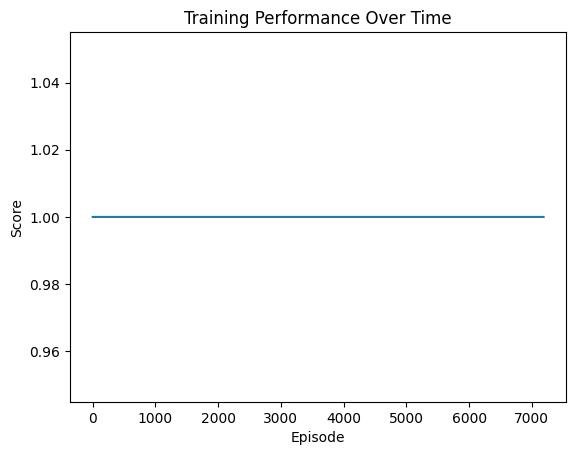

In [ ]:
# Visualisasi hasil training
episodes = len(dataset['Status'])
scores = []
for episode in range(1, episodes + 1):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        action, _ = ppo.select_action(obs)
        obs, reward, done, info = env.step()
        score += reward
    scores.append(score)
    print(f"Episode: {episode}, Score: {score}")

env.close()

# Plotting the scores
plt.plot(range(len(scores)), scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Performance Over Time')
plt.show()


In [ ]:
# Load actual data for comparison
actual_data = dataset
print(actual_data.head())

predicted_statuses = []
actual_statuses = actual_data['Status'].tolist()

def evaluate_and_compare(env, model, n_eval_episodes=10):
    episode_rewards = []
    predicted_statuses = []
    for episode in range(n_eval_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action, _ = model.select_action(state)
            state, reward, done, _ = env.step()
            episode_reward += reward
            if done:
                predicted_statuses.append(action)  # Save the predicted action as the status
        episode_rewards.append(episode_reward)
    return episode_rewards, predicted_statuses

# Evaluasi dan dapatkan predicted status
mean_reward, std_reward = evaluate_policy(env, ppo, n_eval_episodes=max_episodes)
_, predicted_statuses = evaluate_and_compare(env, ppo, n_eval_episodes=max_episodes)

# Comparison
comparison_df = pd.DataFrame({
    'Actual Status': actual_statuses[:len(predicted_statuses)],  # Ensure matching length
    'Predicted Status': predicted_statuses
})

print(comparison_df)

# Visualization
comparison_df.plot(kind='bar', figsize=(10, 5))
plt.xlabel('Episode')
plt.ylabel('Status')
plt.title('Comparison of Actual and Predicted Status')
plt.show()


NameError: name 'dataset' is not defined

In [ ]:
len(predicted_statuses)

1800

Confusion Matrix - Validation Data
[[541 687]
 [ 85 125]]


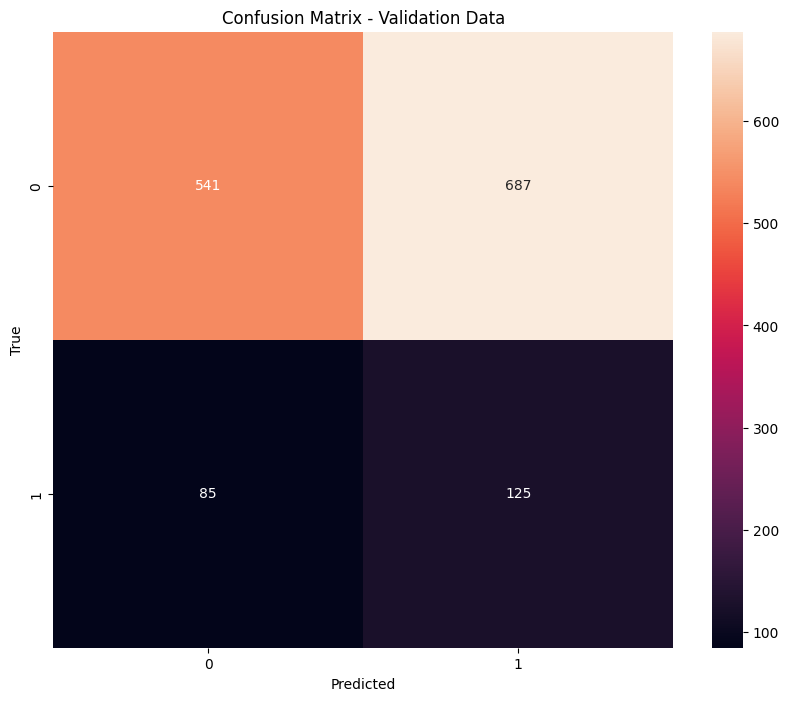

Classification Report - Validation Data
              precision    recall  f1-score   support

           0       0.86      0.44      0.58      1228
           1       0.15      0.60      0.24       210

    accuracy                           0.46      1438
   macro avg       0.51      0.52      0.41      1438
weighted avg       0.76      0.46      0.53      1438



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Menghitung dan menampilkan confusion matrix untuk data validasi
cm_val = confusion_matrix(y_test, predicted_statuses[:1438])
print("Confusion Matrix - Validation Data")
print(cm_val)

# Menampilkan confusion matrix sebagai heatmap untuk data validasi
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# Menghitung dan menampilkan classification report untuk data validasi
print("Classification Report - Validation Data")
report_val = classification_report(y_test, predicted_statuses[:1438])
print(report_val)

In [ ]:
np.unique(predicted_statuses)

array([0, 1])

In [ ]:
# from itertools import product

# # Hyperparameter grid
# learning_rates = [0.0001, 0.0003, 0.001]
# gammas = [0.95, 0.99]
# eps_clips = [0.1, 0.2]
# k_epochs_list = [3, 5]

# best_reward = -float('inf')
# best_params = None

# for lr, gamma, eps_clip, k_epochs in product(learning_rates, gammas, eps_clips, k_epochs_list):
#     ppo = PPO(state_dim, action_dim, lr=lr, gamma=gamma, k_epochs=k_epochs, eps_clip=eps_clip)
#     memory = Memory()
    
#     time_step = 0
#     total_reward = 0

#     for episode in range(1, max_episodes + 1):
#         state = env.reset()
#         episode_reward = 0
#         for t in range(max_timesteps):
#             time_step += 1
#             action, logprob = ppo.select_action(state)
#             next_state, reward, done, _ = env.step()

#             memory.add_state(torch.FloatTensor(state))
#             memory.add_action(torch.tensor(action))
#             memory.add_logprob(torch.tensor(logprob))
#             memory.add_reward(reward)
#             memory.add_is_terminal(done)
            
#             state = next_state
#             episode_reward += reward

#             if time_step % update_timestep == 0:
#                 ppo.update(memory)
#                 memory.clear_memory()
#                 time_step = 0
            
#             if done:
#                 break

#         total_reward += episode_reward

#     # Compare the total reward with the best reward so far
#     if total_reward > best_reward:
#         best_reward = total_reward
#         best_params = (lr, gamma, eps_clip, k_epochs)

# print(f"Best Hyperparameters: Learning Rate: {best_params[0]}, Gamma: {best_params[1]}, Epsilon Clip: {best_params[2]}, K Epochs: {best_params[3]}")

In [ ]:
# print(f"Best Hyperparameters: Learning Rate: {best_params[0]}, Gamma: {best_params[1]}, Epsilon Clip: {best_params[2]}, K Epochs: {best_params[3]}")